# Scrape sessions from team surfs (Smartfin @ Surfrider)

### Imports

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import matplotlib
import pandas as pd
import numpy as np
from scipy import stats
from scipy import constants
from scipy.integrate import cumtrapz
import os
import datetime
import pytz
import re

import requests

import mpld3
import folium
import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

# For the definition of the abstract base class IMU_Base
import abc

import sys

%matplotlib notebook

### Ride list
Create a list of ride (session) identifiers manually (looking at surf.smartfin.org and known fin identifiers).

In [15]:
ride_ids = ['14815']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th

### Set up functions to scrape by ride ID

In [16]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' # OMG I can't believe this is how we're doing this. 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            sample_interval = '250ms'
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample

### Append to lists of dataframes then concatenate and merge
1. First, loop through function(s) above using known session IDs, generating a dataframe for each rid (ride identifier). 
2. Next, append each dataframe (one motion, one temperature DF for each rid) to corresponding lists of DFs.
3. Use pandas concatenate function to turn appended lists into a mega dataframe of all dataframes, using rid as index
4. Rename some cols as needed
5. Merge motion and temperature DFs

*Note*: temp DF is called "ocean" due to surf.smartfin.org's nomenclature (e.g., ocean.csv, ocean.json, etc.)

In [17]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

# Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride ", rid, "so far so good")
            count_good_fins += 1
        
    except: 
        print("Ride ", rid, " ain't workin'")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, whatever that means-> a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

# Just in case it's helpful to have descriptive column headers...
ocean_df.columns.values[1] = 'V_temp_int (ADC counts)'
ocean_df.columns.values[2] = 'temp_int_cal (oC)' # this column is just copied from temp_ext
ocean_df.columns.values[4] = 'V_temp_ext (ADC counts)'
ocean_df.columns.values[5] = 'temp_ext_cal (oC)' 

# Merge to get lat/lon in temp DF
full_df = pd.merge(ocean_df, motion_df, left_index = True, right_index = True)
print(len(full_df))

https://surf.smartfin.org/ride/14815
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180719231539_Ocean.CSV
Ride  14815 so far so good
7412


### Filter using temp, temp rate of change, and motion and modify the CSV data above to give out useful measurements in acceleration, gyro, and magnetic with direction relative to the board

In [18]:
#%% Filter         
# Grab int and ext for better readability
temp_int = full_df.loc[:, 'temp_int_cal (oC)']
temp_ext = full_df.loc[:, 'temp_ext_cal (oC)']
temp_diff_pre = temp_ext-temp_int
diff_temp_diff_pre = np.diff(temp_diff_pre)
diff_temp_diff_pre = np.append(diff_temp_diff_pre, diff_temp_diff_pre[-1]) # derivative of the difference
A2 = full_df.loc[:, 'IMU A2'] # z-dimension (into board)
print(len(A2))

# Get rid of data outside of this temp difference range
simple_filter = (A2 < 2000)
full_df_filt = full_df[simple_filter]

# Grab int and ext again after filter
temp_int = full_df_filt.loc[:, 'temp_int_cal (oC)']
temp_ext = full_df_filt.loc[:, 'temp_ext_cal (oC)']
temp_diff_post = temp_ext-temp_int

full_df_filt.head(20)


full_df_filt_mod = full_df_filt    # Make a copy of the original filtered data as to not modify it in case it
                                   # needs to be called to again for other reasons

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places
# and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2
full_df_filt_mod.loc[:, 'IMU A1'] = full_df_filt_mod.loc[:, 'IMU A1'] / 512 * 9.81
full_df_filt_mod.loc[:, 'IMU A2'] = full_df_filt_mod.loc[:, 'IMU A2'] / 512 * 9.81
full_df_filt_mod.loc[:, 'IMU A3'] = full_df_filt_mod.loc[:, 'IMU A3'] / 512 * 9.81

# Correct the IMU Gyroscopic columns into units of degrees/sec
# Dividing by 8.2 is equivalent to multiplying by 4 to correct bit shifting by 2 places
# and dividing by 32.8 to convert bits into degrees/sec
full_df_filt_mod.loc[:, 'IMU G1'] = full_df_filt_mod.loc[:, 'IMU G1'] / 8.2
full_df_filt_mod.loc[:, 'IMU G2'] = full_df_filt_mod.loc[:, 'IMU G2'] / 8.2
full_df_filt_mod.loc[:, 'IMU G3'] = full_df_filt_mod.loc[:, 'IMU G3'] / 8.2

# Correct the IMU Magnetometer columns into units of microTeslas
# There is no bit shifting done here in the firmware, so we only have to convert bits to microTeslas by multiplying by 0.15
full_df_filt_mod.loc[:, 'IMU M1'] = full_df_filt_mod.loc[:, 'IMU M1'] #* 0.15
full_df_filt_mod.loc[:, 'IMU M2'] = full_df_filt_mod.loc[:, 'IMU M2'] #* 0.15
full_df_filt_mod.loc[:, 'IMU M3'] = full_df_filt_mod.loc[:, 'IMU M3'] - 100 #* 0.15 # -100 is to fix inductive pad field reading

# Edit the titles of the columns so that they display the units of the data presented in each column
# IMPORTANT NOTE!!!! Remember axis direction!!
#      *FOR ACCELERATION AND GYRO, Right-sided fins (in relation to forward movement) have A1 pointed backwards,
#       A2 pointed straight down, and A3 pointed to the right
#      *FOR MAGNETO, right-sided fins have X (M1) pointing down, Y (M2) pointing backwards, and Z (M3) pointing left
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU A1':'IMU A1 [m/s^2] long axis - = forwards', 'IMU A2':'IMU A2 [m/s^2] vertical + = down', 'IMU A3':'IMU A3 [m/s^2] short axis + = right'}))
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU G1':'IMU G1 [deg/s] + = flip left','IMU G2':'IMU G2 [deg/s] + = turning right','IMU G3':'IMU G3 [deg/s] pitch upwards'}))
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU M1':'IMU M1 [uTeslas] + = looking forward','IMU M2':'IMU M2 [uTeslas] + = looking upwards','IMU M3':'IMU M3 [uTeslas] + = looking right'}))
# Not sure if the IMU 1,2,3 correspond with a certain direction (i.e. A2, G2, M2, all face down into water) or that each
#     IMU corresponds with certain labeled axis (i.e. IMU 1 is always X-axis, IMU 2 is always Y-axis...)
# The current labels correspond to ASSUMPTION 1 (CONFIRMED)

# For this table to output the correct values, full_df_filt has to be run again, and this run after it but only once
# I know it has to do with the structure that python handles this with (which would be pointer type) and I don't know how to
#      work around that without going through a lengthy complicated process I'm not sure I can do reliably.

# I will join the two codes into one cell evetually to eliminate this problem, but I keep them separate 
#      for now to keep each step separate.

# Print out the modified table with unit labels
print("For some reason, the table doesn't display IMU A1 column at output.")
print("The proper name for IMU A1 is 'IMU A1 [m/s^2] long axis - = forwards' for reference. Negative value\
means going directly forward on the board.")
full_df_filt_mod.head(20)
#print(full_df)

7412


C:\Users\Kevin\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


For some reason, the table doesn't display IMU A1 column at output.
The proper name for IMU A1 is 'IMU A1 [m/s^2] long axis - = forwards' for reference. Negative valuemeans going directly forward on the board.


Time_x  V_temp_int (ADC counts)  \
ride_id UTC                                                        
14815   2018-07-19 23:15:48.500     NaN                      NaN   
        2018-07-19 23:15:48.750     NaN                      NaN   
        2018-07-19 23:15:49.000     NaN                      NaN   
        2018-07-19 23:15:49.250     NaN                      NaN   
        2018-07-19 23:15:49.500     NaN                      NaN   
        2018-07-19 23:15:49.750     NaN                      NaN   
        2018-07-19 23:15:50.000     NaN                      NaN   
        2018-07-19 23:15:50.250     NaN                      NaN   
        2018-07-19 23:15:50.500     NaN                      NaN   
        2018-07-19 23:15:50.750     NaN                      NaN   
        2018-07-19 23:15:51.000     NaN                      NaN   
        2018-07-19 23:15:51.250     NaN                      NaN   
        2018-07-19 23:15:51.500     NaN                      NaN   
        2018-07-19 23:15:51.750     NaN                      NaN   
        2018-07-19 23:15:52.000     NaN                      NaN   
        2018-07-19 23:15:52.250     NaN                      NaN   
        2018-07-19 23:15:52.500     NaN                      NaN   
        2018-07-19 23:15:52.750     NaN                      NaN   
        2018-07-19 23:15:53.000     NaN                      NaN   
        2018-07-19 23:15:53.250     NaN                      NaN   

                                 temp_int_cal (oC)  Temperature 1 Stable  \
ride_id UTC                                                                
14815   2018-07-19 23:15:48.500                NaN                   NaN   
        2018-07-19 23:15:48.750                NaN                   NaN   
        2018-07-19 23:15:49.000                NaN                   NaN   
        2018-07-19 23:15:49.250                NaN                   NaN   
        2018-07-19 23:15:49.500                NaN                   NaN   
        2018-07-19 23:15:49.750                NaN                   NaN   
        2018-07-19 23:15:50.000                NaN                   NaN   
        2018-07-19 23:15:50.250                NaN                   NaN   
        2018-07-19 23:15:50.500                NaN                   NaN   
        2018-07-19 23:15:50.750                NaN                   NaN   
        2018-07-19 23:15:51.000                NaN                   NaN   
        2018-07-19 23:15:51.250                NaN                   NaN   
        2018-07-19 23:15:51.500                NaN                   NaN   
        2018-07-19 23:15:51.750                NaN                   NaN   
        2018-07-19 23:15:52.000                NaN                   NaN   
        2018-07-19 23:15:52.250                NaN                   NaN   
        2018-07-19 23:15:52.500                NaN                   NaN   
        2018-07-19 23:15:52.750                NaN                   NaN   
        2018-07-19 23:15:53.000                NaN                   NaN   
        2018-07-19 23:15:53.250                NaN                   NaN   

                                 V_temp_ext (ADC counts)  temp_ext_cal (oC)  \
ride_id UTC                                                                   
14815   2018-07-19 23:15:48.500                      NaN                NaN   
        2018-07-19 23:15:48.750                      NaN                NaN   
        2018-07-19 23:15:49.000                      NaN                NaN   
        2018-07-19 23:15:49.250                      NaN                NaN   
        2018-07-19 23:15:49.500                      NaN                NaN   
        2018-07-19 23:15:49.750                      NaN                NaN   
        2018-07-19 23:15:50.000                      NaN                NaN   
        2018-07-19 23:15:50.250                      NaN                NaN   
        2018-07-19 23:15:50.500                      NaN                N

### Calculate elapsed time

In [19]:
#%% Get elapsed time per session after filtering
good_rides = (motion_df.index.get_level_values(0).unique()) # get all names
n_rides = len(good_rides)
idx = pd.IndexSlice

total_sesh_sec = 0 # increment each successful session

# Make plot of each good session (ride)
for n in range(0, n_rides): #n_rides
    this_ride = good_rides[n]
    try:
        this_ride_df = full_df_filt.xs(good_rides[n], level = 'ride_id', axis = 0)
        session_duration_sec = this_ride_df['elapsed'][-1]-this_ride_df['elapsed'][0]
        print(this_ride, session_duration_sec)
        if session_duration_sec/60 > 15:
            total_sesh_sec += session_duration_sec
    except:
        print('meh')

14815 nan


### Calculate Compass Heading Direction from Magnetometer Data

In [20]:
# Iterate through to get the data from the columns and run calculations
y_ax = full_df_filt_mod.loc[:, 'IMU M2 [uTeslas] + = looking upwards'] #* (-1)
x_ax = full_df_filt_mod.loc[:, 'IMU M3 [uTeslas] + = looking right'] #* (-1)
z_ax = full_df_filt_mod.loc[:, 'IMU M1 [uTeslas] + = looking forward']

# The original calculations that I learned this method from used Gauss as units,
# but units cancel anyways in arctan


# Calculate the direction D by first checking to see if the X data is equal to 0 to prevent
# divided by zero erros in calculations. If the X data is 0, check to see if the Y data < 0
# If Y < 0, the direction D = 90 degrees heading; if Y > 0, the direction D = 0 degrees.
# If X data != 0, then calculate the arctan of Y and X and convert from polar to degrees
# If D is greater than 360 degrees, substract 360 degrees from that value
# If D is less than 0 degrees, add 360 degrees to that value

# I got this method from the website below:
# https://blog.digilentinc.com/how-to-convert-magnetometer-data-into-compass-heading/

comp_heading = [np.float(0.0)] * len(x_ax)

#print(comp_heading)
# for i in x_ax:
#    if x_ax[i] == 0.0:
#        if y_ax[i] < 0.0:
#            comp_heading[i] = 90.0
#        elif y_ax[i] > 0.0:
#            comp_heading[i] = 0.0
#        else:
#            print("There was a reading of 0,0 for magnetometer in y-axis and x-axis. List not completed.")
#    else:
#        comp_heading[i] = np.arctan(y_ax[i]/x_ax[i]) * (180.0/np.pi)
#comp_heading = np.arctan(y_ax/x_ax) * (180/np.pi)
print(full_df_filt_mod.loc[:, 'IMU M3 [uTeslas] + = looking right'])
count = 0

print("Converting magneto data from guessed x-axis and y-axis to compass heading in deg:")
#for x in np.nditer(comp_heading, op_flags=['readonly'], op_dtypes=['float64']):
    #for i, j in np.nditer(op=[x_ax, y_ax], op_flags=['readonly'], op_dtypes=['float64']):
for i,j,x in np.nditer([x_ax,y_ax,comp_heading]):
#    for i,j in np.c_[x_ax,y_ax]:
        #print("ij: %f:%f" % (i,j))
    if i == np.float(0):
        print('i = 0')
        if j < np.float(0):
            print('j < 0')
            x = np.float64(90)
        elif j > np.float64(0):
            print('j > 0')
            x = np.float64(0)
        else:
            print("There was a reading of 0,0 for magnetometer in y-axis and x-axis. List not completed")
    else:
        x = np.arctan(j/i) * (180/np.pi)

    if x < np.float64(0):
        x += np.float64(360)
    print(x)
    count+= 1
print("Total number of readings for RID 13735: {}".format(count))


ride_id  UTC                    
14815    2018-07-19 23:15:48.500    -68.0
         2018-07-19 23:15:48.750    -78.0
         2018-07-19 23:15:49.000    -75.0
         2018-07-19 23:15:49.250    -73.0
         2018-07-19 23:15:49.500    -69.0
         2018-07-19 23:15:49.750    -72.0
         2018-07-19 23:15:50.000    -71.0
         2018-07-19 23:15:50.250    -68.0
         2018-07-19 23:15:50.500    -72.0
         2018-07-19 23:15:50.750    -73.0
         2018-07-19 23:15:51.000    -68.0
         2018-07-19 23:15:51.250    -79.0
         2018-07-19 23:15:51.500    -74.0
         2018-07-19 23:15:51.750    -70.0
         2018-07-19 23:15:52.000    -67.0
         2018-07-19 23:15:52.250    -73.0
         2018-07-19 23:15:52.500    -69.0
         2018-07-19 23:15:52.750    -80.0
         2018-07-19 23:15:53.000    -72.0
         2018-07-19 23:15:53.250    -74.0
         2018-07-19 23:15:53.500    -73.0
         2018-07-19 23:15:53.750    -73.0
         2018-07-19 23:15:54.000    -55.0
 

301.78091509298343
302.5548968032681
302.85090839255867
302.98852161363453
305.2175929681927
302.5604379811534
303.9214085817819
303.2152514937372
305.16643603579286
303.4653793463553
301.62555953512884
302.98852161363453
304.0705119978196
303.76823361597553
303.16988667383197
302.6484408499698
304.9456644000056
302.9052429229879
301.9170093251889
303.7655559928579
303.0706778227617
302.93223104134665
304.8343051204573
304.14358665193777
302.7995312726192
304.30778784471596
304.9024956159247
302.9052429229879
302.9052429229879
306.37264685593476
302.7684990787698
304.38034472384487
306.6561084159669
304.9024956159247
304.38034472384487
305.2175929681927
303.9964591482505
303.8510103035582
302.26359979520214
303.2970985197786
302.7684990787698
303.77110817846125
303.3106308245608
306.069409899581
304.5225764039951
304.14358665193777
302.4302081923213
305.735476014867
302.4711922908485
303.69006752597977
303.69006752597977
302.9052429229879
302.0053832080835
306.25383773744477
306.107451

303.69006752597977
305.79959953092964
304.24203291161
304.5225764039951
305.2037900825255
305.0361958100928
304.45193458185787
303.69006752597977
303.84534026107167
305.15098548888295
303.80292840334454
304.14358665193777
305.6704603573019
304.0705119978196
305.5059701142411
303.15173376158555
305.2833141822149
306.86989764584405
305.5376777919744
305.40686573726964
305.35559435989194
302.6849815207256
306.57303097851934
305.16643603579286
304.0705119978196
306.39551840690734
304.7289962795209
305.35195468390185
305.4121669751814
305.84974322198514
304.48737283007864
305.4727166185476
302.22875743509854
302.0053832080835
300.25643716352926
299.93151184050777
299.28142706105905
300.73021524592014
297.42874122167757
293.66314070819436
289.4023278382181
285.01107757799133
283.63146306385295
276.619529736151
284.870957355858
285.0400252808037
282.5903829455351
283.5801323843094
285.1540680503126
285.04639183219854
284.7886776141652
285.74393477789295
284.51278086953954
285.74393477789295
2

288.03775740736756
288.2342639010106
290.2564621745231
288.434948822922
287.98926894798296
289.2376392748868
290.2856990998475
288.73597466701835
288.434948822922
288.2840384269091
289.73918083589484
289.6222561386508
289.1397822586531
288.9419778838368
287.93236715620094
287.50924479025764
289.6222561386508
288.532974013017
287.62229722866823
289.9037495373078
288.33667142442715
289.2826052089042
289.0307240169667
289.2376392748868
288.434948822922
288.38610332792405
288.03428556712987
289.02560603756865
289.0307240169667
288.3353906615868
289.6950588688637
289.1276101660717
288.93753048964305
288.6851471431196
287.83501494266807
288.03428556712987
288.434948822922
288.434948822922
287.83501494266807
288.5359994756672
288.434948822922
288.28599999161816
287.81888891452274
288.03775740736756
289.0466242976358
288.7870694613854
288.63116647881594
287.83501494266807
289.1397822586531
288.434948822922
289.5271104138933
288.8314530780551
289.40597075400115
288.4846847301459
288.73079359220

330.56151032532847
330.56151032532847
331.868657635939
331.6992442339936
331.6992442339936
332.35402463626133
335.79411495550363
329.8454520820838
330.56151032532847
332.0490309721098
333.54366933667194
329.70830389968273
333.22507511135444
331.31385242626055
329.4593951503185
330.94539590092285
331.89864869403823
331.47688139368796
333.10376303450664
331.9553130520252
334.09349200048564
332.10272896905235
334.09349200048564
329.5110595001691
332.35402463626133
332.10272896905235
330.9935840977299
327.94650951563693
330.06848815949223
334.55825153699743
336.4129694748718
330.06848815949223
333.65788847411955
332.31164610884656
332.7838884426925
330.1952485268199
332.31164610884656
332.5255683737229
332.77132082290876
331.9553130520252
332.71579270637693
334.6538240580533
329.63572899983967
334.29004621918875
330.1952485268199
330.751173663453
326.9060520219452
330.751173663453
333.21709519782485
331.89864869403823
332.99590929724036
331.8374726256764
330.3762512488262
332.9873346520614

305.0636100565717
306.28526712513883
305.2316498323643
305.81116392264124
306.40877456777235
305.4010969314582
306.95494822095
306.15818543980834
305.81116392264124
303.69006752597977
305.4010969314582
308.4337013792537
304.87532834460217
306.40877456777235
306.2692150262632
305.13419305691565
307.1042349057062
305.94211187138234
306.17613805695953
308.1731376615263
304.6583547055211
307.9772061644268
306.9267951241748
305.60453398043313
306.694323794444
305.2724214485984
305.19643239565494
304.5085229876684
306.28526712513883
303.61082030194547
306.52885536698517
306.7311672159564
304.99202019855863
306.34745820888526
306.34745820888526
306.55046173880703
306.86989764584405
305.6704603573019
304.8040117527132
304.8827004211844
308.4337013792537
309.3296426561061
307.2713630040484
305.7778383355235
306.58765470957314
306.9267951241748
307.32552048310606
306.4391104288354
305.8771037946215
306.86989764584405
304.0841175683069
305.39801742381485
305.46987216740007
306.9829069263447
308.5

299.49746120836835
299.2192466904846
299.27907221417723
297.98745319075596
299.7448812969422
300.2770249382498
300.56793706386406
300.9637565320735
300.9637565320735
300.9637565320735
300.579226872489
301.75948008481276
299.2192466904846
302.2948303099024
299.85429385556984
299.38901146632037
300.9637565320735
300.66892664971493
298.8865817669107
301.45682335755527
299.886526940424
301.1621826808196
299.5387822595581
299.886526940424
300.4655449194599
299.8657218699812
299.49746120836835
300.7685416843574
301.0622027917458
299.6237487511738
297.4542712543037
303.84534026107167
302.82081894747586
299.33422989028253
300.3791260113683
300.58989052014425
301.75948008481276
301.75948008481276
301.64465903709254
300.17352002964435
302.33937707974127
301.7940720183315
299.5387822595581
297.9560660636843
298.5658367937466
300.47985098146296
300.86680945113704
301.1593045083444
300.8608916883495
298.45323918381894
300.17352002964435
300.3617214616263
301.64465903709254
300.094241476445
297.8380

287.87374364119313
288.7413404451927
287.09070971613176
287.41191863425416
287.16754983768874
287.0205256115199
287.0079469554073
287.0205256115199
287.5699805679598
286.29879638153733
287.92791976200726
286.65430637692333
286.85372156125777
287.10272896905235
286.3895403340348
286.6230328137722
288.28065176455726
287.5174791771773
286.7925091209847
287.92339295633496
287.7263799008152
287.0205256115199
288.6399417926469
286.91417916177824
288.18365315571305
287.30560840685837
287.0205256115199
287.71363719005
287.2678800276645
286.91417916177824
286.8070877357302
288.2288497855379
287.2149923925478
287.19854122006586
287.80764783569646
287.2095575205479
286.973895667244
287.3254861464183
287.1261341064405
286.6992442339936
287.0734216675096
286.4986403853174
286.96883212874843
286.94061523165544
287.58135006077066
287.8297342256772
286.82140989004085
287.7263799008152
286.6230328137722
287.71363719005
286.7776670970281
286.1403524323101
287.5174791771773
287.4298628176678
288.43494882

### Graphing the compass heading (w/ 0 deg being North)

In [21]:
# First have to correct compass heading data and subtract 90 deg to make "North"
# oriented the right way
# You HAVE TO re run the above code before running this code every time
#comp_heading -= np.float(90)

#r = np.ones(161)
#theta = comp_heading * 2*np.pi / 360
#ax = plt.subplot(111, projection='polar')
#ax.plot(theta, r)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])
#ax.set_rlabel_position(-22.5)
#ax.grid(True)


#ax.set_title("Plot of compass heading for RID 13735: North = 0", va='bottom')
#plt.show()

### Set up plots using newly filtered data

In [22]:
#%% Redundantly get lat/lon from newly filtered DF
lons = full_df_filt.Longitude/100000
lats = full_df_filt.Latitude/100000
temps = full_df_filt.loc[:, 'temp_ext_cal (oC)']
daytimes = full_df_filt.index.get_level_values(-1)

pacific = pytz.timezone('US/Pacific')
daytimes = daytimes.tz_localize(pytz.utc).tz_convert(pacific)

max_temp = 35#max(np.nanmax(temps)) # reset based on filtered data
min_temp = 5#min(np.nanmin(temps))

#%% Plot

# Colormap from cmocean package
#cm = cmocean.cm.thermal
#cm = plt.cm.seismic
cm = plt.cm.RdBu_r
#cm = plt.cm.Pastel1

# Set lat/lon bounds based on current extent.
lon_max = max(np.nanmax(lons))
lon_min = min(np.nanmin(lons))
lon_range = lon_max-lon_min

lat_max = max(np.nanmax(lats))
lat_min = min(np.nanmin(lats))
lat_range = lat_max-lat_min

lon_buf = .1 # fraction extra space added to each side
lat_buf = .1

LL_lon = lon_min-lon_buf*lon_range # lower left longitude
UR_lon = lon_max+lon_buf*lon_range
LL_lat = lat_min-lat_buf*lat_range
UR_lat = lat_max+lat_buf*lat_range

scale_temps = (temps-min_temp)/(max_temp-min_temp)
temps_fahr = temps*9/5+32
fin_series = full_df_filt.index.get_level_values(0)

TypeError: 'numpy.float64' object is not iterable

### Create a folium map instance, add some layers, and plot points as CircleMarkers

In [ ]:
# Colormap from cmocean package
cm = cmocean.cm.thermal
#cm = plt.cm.seismic

# Create map
#m =  folium.Map(location = [32.875, -117.265]) #, tiles = 'Stamen Terrain'
#m =  folium.Map(location = [32.875, -117.265], tiles = 'Stamen Terrain')
mapa =  folium.Map(location = [32.875, -117.265]) #, tiles = 'Stamen Terrain'

# Get nicer tiles
pre = 'http://services.arcgisonline.com/arcgis/rest/services'
pos = 'MapServer/tile/{z}/{y}/{x}'
tile = 'Ocean/World_Ocean_Base'
ESRI = dict(World_Ocean_Base='Ocean/World_Ocean_Base',
            World_Ocean_Reference='Ocean/World_Ocean_Reference',
            )
#            NatGeo_World_Map='NatGeo_World_Map/MapServer',
#            World_Imagery='World_Imagery/MapServer',
#            World_Physical_Map='World_Physical_Map/MapServer',
#            World_Shaded_Relief='World_Shaded_Relief/MapServer',
#            World_Street_Map='World_Street_Map/MapServer',
#            World_Terrain_Base='World_Terrain_Base/MapServer',
#            World_Topo_Map='World_Topo_Map/MapServer')

# Add pretty tiles and names
for name, tile in ESRI.items():
    url = '{}/{}/{}'.format(pre, tile, pos)
    w = folium.TileLayer(tiles=url,
                         name=name,
                         attr='ESRI',
                         overlay=True)
    w.add_to(mapa)
    
mapa.add_child(folium.LayerControl())
#

for lat, lon, temp, scale_temp, daytime, fin in zip(lats, lons, temps_fahr, scale_temps, daytimes, fin_series):
    # Get RGB components of RGBA
    rgb = cm(scale_temp)[:3]
    hexclr = matplotlib.colors.rgb2hex(rgb)
    daytimestr = str(daytime.date())+" "+str(daytime.time())+", "
    mypopup = daytimestr+str('% 10.2f' % temp)+" F, session = "+str(fin)
    
    # Add markers
    if ~np.isnan(lat) and ~np.isnan(lon) and ~np.isnan(scale_temp):
        folium.CircleMarker([lat, lon],
                                radius = 7,
                                popup = mypopup,
                                color = None,
                                fill = True,
                                fill_color = hexclr,
                                fill_opacity = 0.5,
                               ).add_to(mapa)

mapa

figname = '../Figures/interact_'+str(datetime.datetime.now().date())+'.html'

mapa.save(figname)


<IPython.core.display.Javascript object>


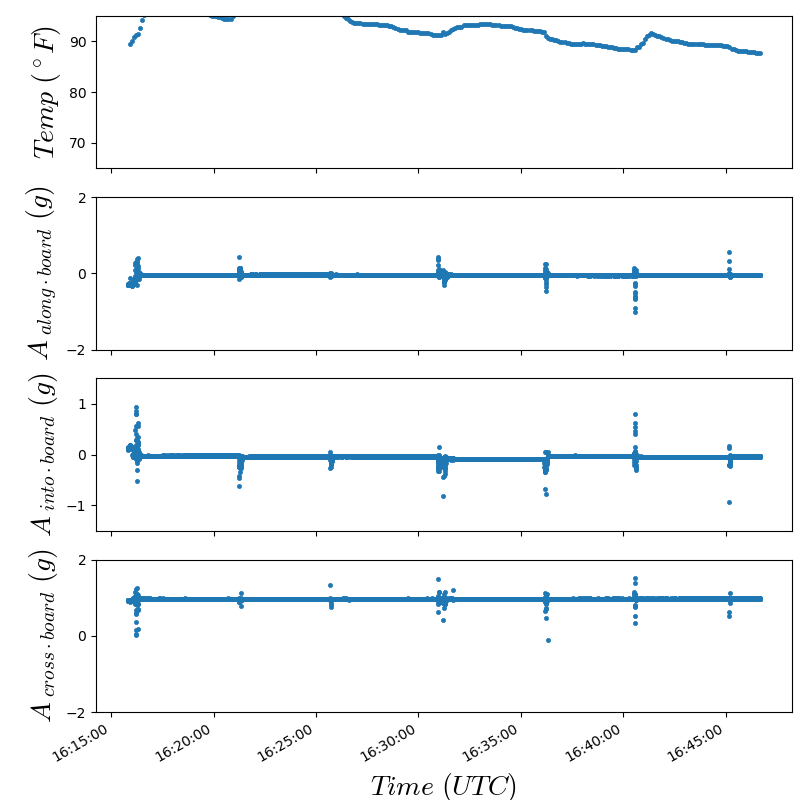

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


DatetimeIndex(['2018-07-19 16:15:48.500000-07:00',
               '2018-07-19 16:15:48.750000-07:00',
                      '2018-07-19 16:15:49-07:00',
               '2018-07-19 16:15:49.250000-07:00',
               '2018-07-19 16:15:49.500000-07:00',
               '2018-07-19 16:15:49.750000-07:00',
                      '2018-07-19 16:15:50-07:00',
               '2018-07-19 16:15:50.250000-07:00',
               '2018-07-19 16:15:50.500000-07:00',
               '2018-07-19 16:15:50.750000-07:00',
               ...
                      '2018-07-19 16:46:39-07:00',
               '2018-07-19 16:46:39.250000-07:00',
               '2018-07-19 16:46:39.500000-07:00',
               '2018-07-19 16:46:39.750000-07:00',
                      '2018-07-19 16:46:40-07:00',
               '2018-07-19 16:46:40.250000-07:00',
               '2018-07-19 16:46:40.500000-07:00',
               '2018-07-19 16:46:40.750000-07:00',
                      '2018-07-19 16:46:41-07:00',
            

In [23]:
#%% Plot!
fig, axs = plt.subplots(figsize = (8, 8), nrows = 4, sharex = True)
n_lines = len(ride_ids)
fsize = 20

# Set sequential color-mapping
plt.style.use('classic')
plt.style.use('fivethirtyeight')

# Nested loops to plot by fin, by ride
for i, rid in enumerate(ride_ids):
    # Fetch one ride at a time
    full_df_ride = full_df.ix[rid]
    
    # Y variables
    temp_ride = full_df_ride.loc[:, 'temp_ext_cal (oC)']
    #These were changed from /500 to /512 to fit our control findings
    A1_ride = full_df_ride.loc[:, 'IMU A1']/512
    A2_ride = full_df_ride.loc[:, 'IMU A2']/512
    A3_ride = full_df_ride.loc[:, 'IMU A3']/512
                              
    #These were changed from /500 to /8.2 to fit our control findings
    G1_ride = full_df_ride.loc[:, 'IMU G1']/8.2
    G2_ride = full_df_ride.loc[:, 'IMU G2']/8.2
    G3_ride = full_df_ride.loc[:, 'IMU G3']/8.2
    
    # Time or elapsed time on x-axis
    x_var = full_df_ride.index # this puts them all over the x-axis due to long time between sessions
    
    # Convert to local time but only here...
    pacific = pytz.timezone('US/Pacific')
    x_var_local = x_var.tz_localize(pytz.utc).tz_convert(pacific)
    
    # Plot
    axs[0].plot(x_var_local, temp_ride*1.8+32, '.', label = 'surfer '+str(i)) # full_df_ride.index, 
#    axs[0].set_ylim([17, 18])
    axs[0].set_ylabel('$Temp\ (^\circ F)$', fontsize = fsize)
        
    axs[1].plot(x_var_local, A1_ride, '.')
    axs[2].plot(x_var_local, A2_ride, '.')
    axs[3].plot(x_var_local, A3_ride, '.')
    
#    axs[2].plot(x_var, G1_ride, '.')
#    axs[2].plot(x_var, G2_ride, '.')
#    axs[2].plot(x_var, G3_ride, '.')
    
    axs[1].set_ylabel('$A_{\ along \cdot board}\ (g)$', fontsize = fsize)
    axs[2].set_ylabel('$A_{\ into \cdot board}\ (g)$', fontsize = fsize)
    axs[3].set_ylabel('$A_{\ cross \cdot board}\ (g)$', fontsize = fsize)
    
    axs[3].set_xlabel('$Time\ (UTC)$', fontsize = fsize)
    
    axs[0].set_ylim([65, 95.])
    axs[1].set_ylim([-2.00, 2.00])
    axs[2].set_ylim([-1.50, 1.50])
    axs[3].set_ylim([-2.00, 2.00])
    
#leg = axs[0].legend(loc = 'lower right', fontsize = fsize-6)
fig.autofmt_xdate()
#fig.tight_layout()
plt.subplots_adjust(left = 0.12, right = 0.99, top = 0.98, bottom = 0.11,
                    hspace = 0.19, wspace = 0.00)
date_format = '%H:%M:%S'
myFmt = mdates.DateFormatter(date_format, tz = pacific)
axs[2].xaxis.set_major_formatter(myFmt)

#plt.savefig('/Users/pjb/Desktop/PJB-JR-SmartfinSurf.png', dpi = 1200)
plt.show()

print(x_var_local)

### Checking data for Swells and their Periods

### Importing Sensor Data and Setting Up for Scikit Kinematics

#### Make sure rate is set to either 4 Hz or 33 Hz

In [24]:
# Get data from CSV for acceleration, gyro, and magneto

# So to use Scikit properly..., it needs an in-File to read to get the data
# I tried to do this without using an input file since the data is still scaled in the CSV, and I'm not sure if that will
#      affect the output of the quaternions. The main concern is the scaling of the magnetometer and acceleration data,
#      since the angular velocity just has to be converted to rad/s, which is simple to do.

rate = 4     #Update frequency in Hz for surfing motion

#initial_orientation = np.eye(3)
#print(initial_orientation)
#initial_position = np.array([0,0,0])

#MPU9250 = Xsens(inFile=None, q_type='kalman', R_init=initial_orientation, calculate_position=True, pos_init=initial_position, in_data=None)

#MPU9250 = imus.IMU_Base(inFile=None, q_type='kalman', R_init=initial_orientation, calculate_position=True, pos_init=initial_position, in_data=None)
# Just using kalman option for now, since "None" seems to be more complicated
                        

acc = full_df_filt_mod.loc[:,['IMU A1 [m/s^2] long axis - = forwards', 'IMU A2 [m/s^2] vertical + = down',\
                              'IMU A3 [m/s^2] short axis + = right']]
# print(acc.size)    #Check to make sure thr right number of numbers are present, should by 161*3 = 483


gyr = full_df_filt_mod.loc[:,['IMU G1 [deg/s] + = flip left', 'IMU G2 [deg/s] + = turning right', 'IMU G3 [deg/s] pitch upwards']]
#print(gyr.size)

gyr_rad = gyr * np.pi / np.float(180)     #Convert gyroscope readings from deg/s to rad/s for input to Scikit functions
#print(gyr_rad)


magn = full_df_filt_mod.loc[:,['IMU M1 [uTeslas] + = looking forward', 'IMU M2 [uTeslas] + = looking upwards', 'IMU M3 [uTeslas] + = looking right']]
#print(magn.size)

# Convert the sliced dataframes into ndarrays for the kalman function below
acc = acc.values
gyr_rad = gyr_rad.values
magn = magn.values

### Getting Quaternions from IMU Data using Kalman's function

Currently we're getting a lot of drift in the gyroscopic readings. The initial magneto readings seem to be aligning with the axis in the animation, but eventually get offset by the gyro drift.

We'll have to find a good calibration to get rid of this if we use the Kalman function here. Hopefully the other functions can eliminate this drift. Otherwise, we may have to manually write code to do these quaternion functions...

In [25]:
# Calculate the quaternions relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data. All functions automatically iterate through arrays unless specified otherwise
quat_array = imus.kalman(rate,acc,gyr_rad,magn)
#print(quat_array)

deg_from_quats = quat.quat2deg(quat_array)     # Find rotational angles from the quaternion orientation
#print(deg_from_quats)


calc_angular_vel = quat.calc_angvel(quat_array, rate, winSize = 3, order = 2)     #Find ang velocities based on quaternions
#print(calc_angular_vel)
print(len(quat_array))
print(quat_array)

#view.orientation(quat_array, out_file=None, title_text='Ride 13735 Filtered', deltaT = 1000)
viewer = view.Orientation_OGL(quat_array, rate = 33) #Make the simulation run at 250ms intervals, so show "real time" movement
viewer.run(looping=False, rate=30)                     #Force the simulation to run at 4Hz to match the 250ms intervals
# Close the window to prevent kernel crash at the end
pygame.display.quit()
pygame.quit()
#view.ts(quat_array)

7404
[[ 1.          0.          0.          0.        ]
 [ 0.99909136 -0.02298014  0.00758747 -0.03508286]
 [ 0.99788573 -0.03583403  0.01452937 -0.05223875]
 ...
 [ 0.15886928 -0.21275234  0.34854317  0.89889635]
 [ 0.15754648 -0.21046508  0.34679322  0.90034328]
 [ 0.15538636 -0.20811092  0.34363745  0.90247339]]


NameError: name 'quit' is not defined

### Using Madgwick's Algorithm

In [25]:
# Calculate the quaternion's relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data, as well as a B (beta) error offset for gyroscopic readings. All functions automatically iterate
#     through arrays unless specified otherwise


# Madgwick class
# SamplePeriod -> seconds, Beta -> average gyroscopic error for each axis (I averaged axes to get single number)
#     Beta = sqrt(3/4) * (error in bits)/8.2 * (pi/180)
calculator = imus.Madgwick(SamplePeriod=0.250, Beta=0.015299, Quaternion=[1, 1, 1, 1])
print(len(gyr_rad))
print(gyr_rad.shape)
print(len(acc))
print(acc.shape)
print(len(magn))
print(magn.shape)
calculator.Update(gyr_rad, acc, magn)

7022
(7022, 3)
7022
(7022, 3)
7022
(7022, 3)


ValueError: all the input arrays must have same number of dimensions